## Data Unzip

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from glob import glob

import pretty_midi
pretty_midi.pretty_midi.MAX_TICK = 1e10

torch.set_printoptions(sci_mode=False)

In [2]:
maestro_path = Path('/home/dasol/userdata/onsets-and-frames/datasets/maestro')

In [3]:
def time2frame(time, sr=16000, hop_length=512):
    return round((time * sr) / hop_length)

In [4]:
class MAESTRODataset:
    def __init__(self, path, split):
        train_path = path / 'train'
        test_path = path / 'test'
        self.path = train_path if split == 'train' else test_path
        self.sample_rate = 16000

        self.files = sorted(list(self.path.glob('*.pt')))[:50] # 작은 학습 데이터셋에 대해서 acc는 높고 f1은 높게 나오는지 확인, loss는 낮게
        self.data = [torch.load(x) for x in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = self.data[idx]
        audio = data['audio']
        roll = np.array(data['label'], dtype=np.float32)

        start = random.randint(0, len(audio) - (self.sample_rate * 25) - 1)
        end = start + (self.sample_rate * 20)
        sliced_audio = audio[start:end]

        start_roll = time2frame(start/self.sample_rate)
        end_roll = start_roll + int(20 * self.sample_rate/512)
        sliced_roll = roll[:, :, start_roll:end_roll]

        return sliced_audio, sliced_roll    

In [5]:
trainset = MAESTRODataset(maestro_path, 'train')
testset = MAESTRODataset(maestro_path, 'test')

In [6]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=10, num_workers=0)
batch = next(iter(train_loader))

In [7]:
batch[0].shape, batch[1].shape

(torch.Size([8, 320000]), torch.Size([8, 2, 88, 625]))

#### Label끼리 잘 맞나 확인

In [8]:
def check_label(split: str, idx, slice: int):
    if split == 'train':
        _, label = trainset[idx]
    elif split == 'test':
        _, label = testset[idx]
    plt.figure(figsize=(15, 7))
    plt.imshow((label[0] + label[1])[:, :slice], aspect='auto', interpolation='nearest', origin='lower')

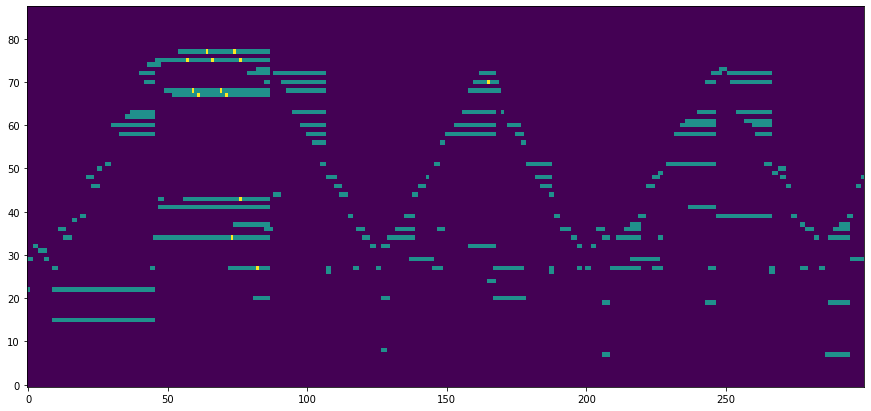

In [9]:
check_label('train', 17, 300)

#### audio-label끼리 잘 맞나 확인

In [10]:
test_audio, test_roll = trainset[77]

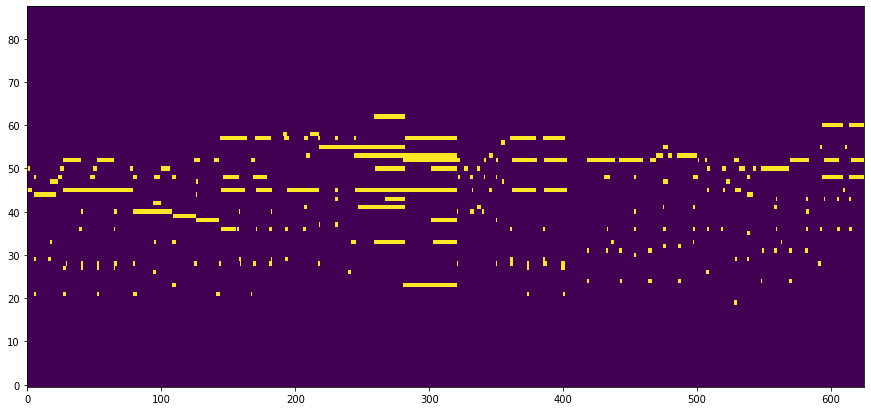

In [11]:
plt.figure(figsize=(15, 7))
plt.imshow(test_roll[0], aspect='auto', interpolation='nearest', origin='lower')

In [12]:
test_audio = test_audio.view([1, -1])
test_audio.shape

torch.Size([1, 320000])

In [13]:
torchaudio.save(filepath='/Users/idasol/Desktop/Visual_Studio_Projects/onsets_and_frames/audio_samples/sample11.wav', src= test_audio, sample_rate=16000)

formats: can't open output file `/Users/idasol/Desktop/Visual_Studio_Projects/onsets_and_frames/audio_samples/sample11.wav': No such file or directory


RuntimeError: Error saving audio file: failed to open file /Users/idasol/Desktop/Visual_Studio_Projects/onsets_and_frames/audio_samples/sample11.wav

## Model

In [14]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2 
WINDOW_LENGTH = 2048

DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# cuda = torch.device('cuda')

In [15]:
class ConvStack(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Sequential(
            nn.Linear(88 * hidden_size, hidden_size),
            nn.Dropout(0.5)
        )

    def forward(self, mel_spec):
        out = self.cnn(mel_spec)
        out = out.reshape(mel_spec.shape[0], -1, mel_spec.shape[-1])
        out = self.fc(out.permute(0, 2, 1))
        return out

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, input_features=256, hidden_size=128):
        super().__init__()
        self.rnn = nn.LSTM(input_features, hidden_size, num_layers=3, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [17]:
class OnsetandFrameModel(nn.Module):
    def __init__(self): 
        super().__init__()
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                  n_fft = 2048,
                                                                  hop_length = 512,
                                                                  f_min = 20,
                                                                  f_max = 8000,
                                                                  n_mels = 88 * 4)

        # sequence_model = lambda input_size, output_size: BiLSTM(input_size, output_size // 2)

        self.onset_stack = nn.Sequential(
            ConvStack(),
            BiLSTM(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        )
        self.frame_stack = nn.Sequential(
            ConvStack(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        )
        self.combined_stack = nn.Sequential(
            BiLSTM(176, 128),
            nn.Linear(256, 88),
            nn.Sigmoid()
        )

    def forward(self, x):
        mel_spec = self.mel_converter(x).unsqueeze(1)
        onset_pred = self.onset_stack(mel_spec)
        # offset_pred = self.offset_stack(mel_spec)
        activation_pred = self.frame_stack(mel_spec)
        combined_pred = torch.cat([onset_pred.detach(), activation_pred], dim=-1)
        frame_pred = self.combined_stack(combined_pred)
        # velocity_pred = self.velocity_stack(mel_spec)
        return onset_pred.permute(0, 2, 1), activation_pred.permute(0, 2, 1), frame_pred.permute(0, 2, 1)

In [19]:
def f1_score(threshold, roll):
    true_positive = ((threshold==1) * (roll==1)).sum()
    false_positive = ((threshold==1) * (roll==0)).sum()
    false_negative = ((threshold==0) * (roll==1)).sum()

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    f1_score = 2 / ((1 / precision) + (1 / recall))

    return f1_score

In [22]:
lr = 1e-4
# model = OnsetandFrameModel().to(device=DEFAULT_DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# BCEloss = nn.BCELoss()
num_epochs = 50 # 원하는대로
# loss_record = []
# test_record = []
# f1_record = []
model.train()

for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        onset_pred, activation_pred, frame_pred = model(audio.to(device=DEFAULT_DEVICE))
        onset_loss = BCEloss(onset_pred[..., :-1].to(torch.float32), roll[:, 1].to(DEFAULT_DEVICE).to(torch.float32))
        frame_loss = BCEloss(frame_pred[..., :-1].to(torch.float32), roll[:, 0].to(DEFAULT_DEVICE).to(torch.float32))
        loss = onset_loss + frame_loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for batch in test_loader:
            audio, roll = batch
            onset_test_pred, activation_test_pred, frame_test_pred = model(audio.to(device=DEFAULT_DEVICE))
            onset_test_loss = BCEloss(onset_test_pred[..., :-1].to(torch.float32), roll[:, 1].to(DEFAULT_DEVICE).to(torch.float32))
            frame_test_loss = BCEloss(frame_test_pred[..., :-1].to(torch.float32), roll[:, 0].to(DEFAULT_DEVICE).to(torch.float32))
            test_loss = onset_test_loss + frame_test_loss
            epoch_loss += test_loss.item()

            # TODO : Calculate accuracy (F1 score)
            roll = roll.to(torch.int).to(DEFAULT_DEVICE)
            # onset_threshold = (onset_test_pred>=0.01).to(torch.int)[..., :-1]
            frame_threshold = (frame_test_pred>=0.1).to(torch.int)[..., :-1]

            # onset_f1_score = f1_score(onset_threshold.to(DEFAULT_DEVICE), roll[:, 1])
            frame_f1_score = f1_score(frame_threshold.to(DEFAULT_DEVICE), roll[:, 0])
            f1_record.append((onset_f1_score + frame_f1_score) / 2)

        test_record.append(epoch_loss / len(test_loader))
    model.train()

100%|██████████| 50/50 [33:31<00:00, 40.22s/it]


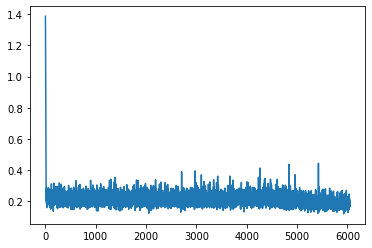

In [23]:
plt.plot(loss_record)

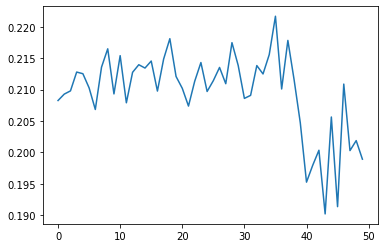

In [24]:
plt.plot(test_record)

In [34]:
f1_record

[tensor(0.0952, device='cuda:0'),
 tensor(0.0822, device='cuda:0'),
 tensor(0.0870, device='cuda:0'),
 tensor(0.0959, device='cuda:0'),
 tensor(0.1179, device='cuda:0'),
 tensor(0.1114, device='cuda:0'),
 tensor(0.0957, device='cuda:0'),
 tensor(0.0908, device='cuda:0'),
 tensor(0.1237, device='cuda:0'),
 tensor(0.1089, device='cuda:0'),
 tensor(0.0996, device='cuda:0'),
 tensor(0.0862, device='cuda:0'),
 tensor(0.1067, device='cuda:0'),
 tensor(0.0910, device='cuda:0'),
 tensor(0.1110, device='cuda:0'),
 tensor(0.1072, device='cuda:0'),
 tensor(0.0814, device='cuda:0'),
 tensor(0.1044, device='cuda:0'),
 tensor(0.1043, device='cuda:0'),
 tensor(0.1017, device='cuda:0'),
 tensor(0.0881, device='cuda:0'),
 tensor(0.1007, device='cuda:0'),
 tensor(0.0887, device='cuda:0'),
 tensor(0.0927, device='cuda:0'),
 tensor(0.0941, device='cuda:0'),
 tensor(0.1062, device='cuda:0'),
 tensor(0.0824, device='cuda:0'),
 tensor(0.0926, device='cuda:0'),
 tensor(0.1130, device='cuda:0'),
 tensor(0.0979